In [400]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from pathlib import Path
sns.set_theme(style="darkgrid", palette="tab20")
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [303]:
feature_path =  Path(r'Z:\20211014_bio325_test\features')
feature_files = feature_path.glob('*cells_feature_values.csv')
feature_files = [str(fyle) for fyle in feature_files]
fv = []

for site, fyle in enumerate(sorted(feature_files)):
    site_fv = pd.read_csv(fyle)
    site_fv['site'] = site
    site_fv['unique_track_id'] = site_fv['track_id'] + site * 1000
    fv.append(site_fv)
    
    
fv = pd.concat(fv)

In [304]:
fv.shape

(1823, 248)

In [305]:
fv.head()

,unique_object_id,timepoint,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,...,perimeter_cytoplasm,solidity_cytoplasm,max_intensity_sdcGFP_cytoplasm,mean_intensity_sdcGFP_cytoplasm,min_intensity_sdcGFP_cytoplasm,blob_count_sdcGFP_cytoplasm,is_border_cytoplasm,site,unique_track_id,count_cytoplasm
0,0,0,1,193163,0,0,737,563,414931,328.429953,...,3952.450793,0.536383,581.0,11.499358,0.0,28.0,1.0,0,2,NaN
1,1,0,2,110729,0,375,536,697,172592,199.811495,...,2289.740115,0.495588,205.0,4.961404,0.0,0.0,1.0,0,3,NaN
2,2,0,3,22289,0,1138,134,1352,28676,55.954372,...,686.727922,0.925469,95.0,5.749069,0.0,1.0,1.0,0,26,NaN
3,3,0,4,229916,14,523,964,1165,609900,469.128547,...,4125.107648,0.660710,123.0,5.378520,0.0,5.0,0.0,0,4,NaN
4,4,0,5,166034,94,951,817,1326,271125,480.333679,...,3342.509668,0.566149,184.0,7.232483,0.0,13.0,0.0,0,5,NaN


# Data clean-up

In [308]:
# remove tracks that contain cells touching the border
fv = fv.groupby('unique_track_id').filter(lambda x: x['is_border'].sum() == 0)
len(fv)

723

In [325]:
# remove tracks that do not span the whole movie
fv = fv.groupby('unique_track_id').filter(lambda x: len(x) == 11)
len(fv)

440

In [335]:
# how many tracks are left?
len(np.unique(fv['unique_track_id']))

40

In [342]:
# add time column
time_resolution_min = 0.5
fv['time'] = fv['timepoint'] * time_resolution_min

# Example plots

[Text(0.5, 0, 'cell area'), Text(0, 0.5, 'nuclei area')]

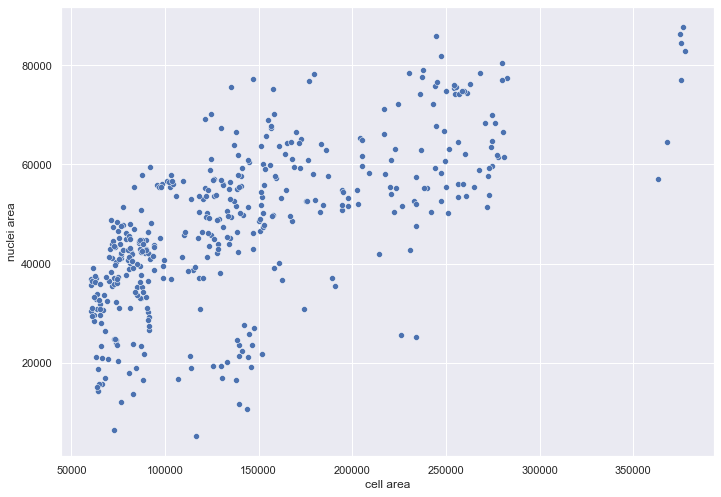

In [351]:
ax = sns.scatterplot(data=fv, x='area', y='area_nuclei')
ax.set(xlabel='cell area', ylabel='nuclei area')

[Text(0.5, 0, 'time (min)'), Text(0, 0.5, 'area nuclei')]

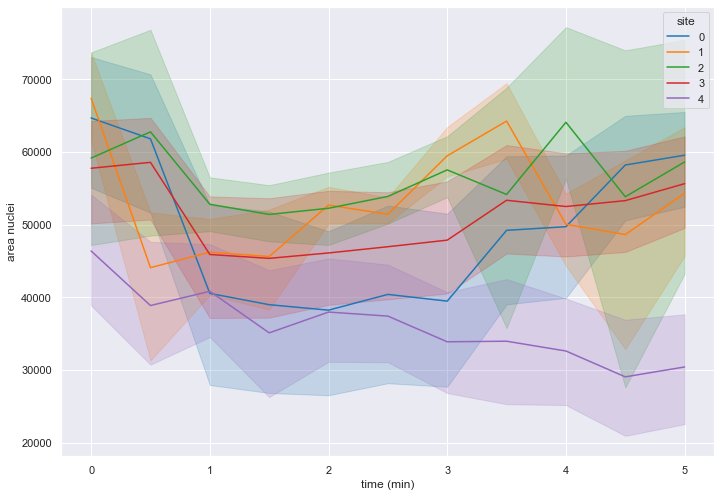

In [352]:
ax = sns.lineplot(data=fv.set_index('unique_object_id'), x='time', y='area_nuclei', hue='site', palette='tab10')
ax.set(xlabel='time (min)', ylabel='area nuclei')

# Volume and density estimation

In [545]:
# volume = area_pixel * pixel_size_um * imaging_depth_um 
fv['volume_cytoplasm'] = fv['area_cytoplasm'] * 6.5/60 * 1
fv['area_cytoplasm_um'] = fv['area_cytoplasm'] * 6.5/60
fv['blob_sdcGFP_cytoplasm_density'] = fv['blob_count_sdcGFP_cytoplasm']/fv['volume_cytoplasm']

In [546]:
# filter the cells that have been transfected in the first timepoint
positive_tracks = fv['unique_track_id'].loc[(fv['timepoint'] == 0) & (fv['max_intensity_sdcGFP'] > 100)]                                        
fv_transfected = fv.loc[fv['unique_track_id'].isin(positive_tracks)]

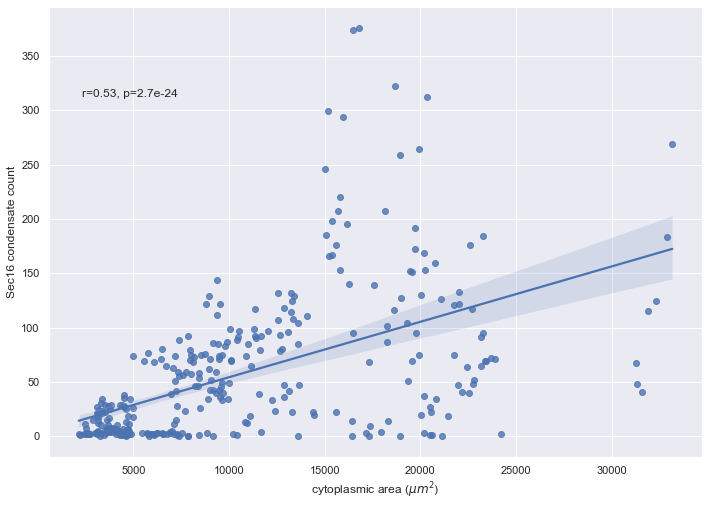

In [547]:
def annotate(ax, data, x, y):
    r, p = sp.stats.pearsonr(data[x], data[y])
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)


ax = sns.regplot(data=fv_transfected, x='area_cytoplasm_um', y='blob_count_sdcGFP_cytoplasm')
ax.set(xlabel='cytoplasmic area ($\mu m^2$)', ylabel='Sec16 condensate count')

annotate(ax=ax, data=fv_transfected, x='area_cytoplasm_um', y='blob_count_sdcGFP_cytoplasm')
plt.show()

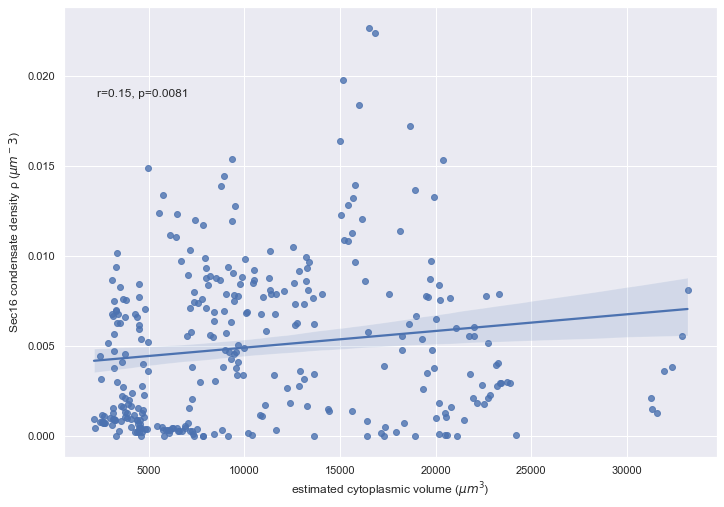

In [548]:
ax = sns.regplot(data=fv_transfected, x='volume_cytoplasm', y='blob_sdcGFP_cytoplasm_density')
ax.set(xlabel='estimated cytoplasmic volume ($\mu m^3$)', ylabel='Sec16 condensate density ρ ($\mu m^-3$)')
annotate(ax=ax, data=fv_transfected, x='volume_cytoplasm', y='blob_sdcGFP_cytoplasm_density')
plt.show()

# Estimation of nucleation rate

[Text(0.5, 0, 'time (min)'),
 Text(0, 0.5, 'Sec16 condensate density ρ ($\\mu m^-3$)')]

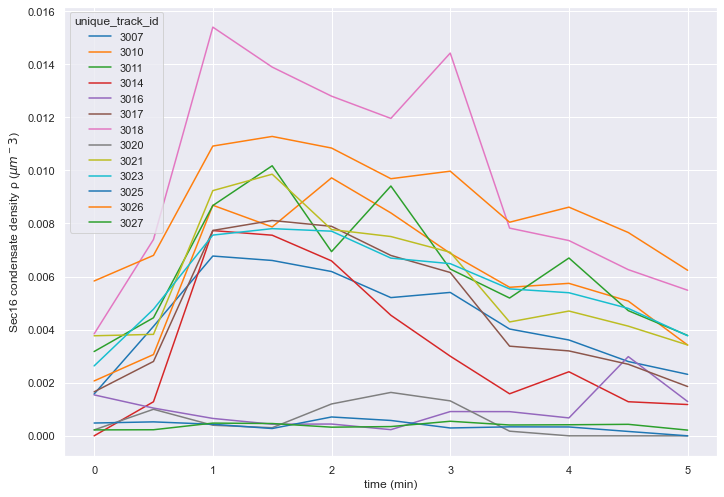

In [549]:
ax = sns.lineplot(data=fv_transfected.loc[fv_transfected['site']==3], x='time', y='blob_sdcGFP_cytoplasm_density', hue='unique_track_id', palette='tab10')
ax.set(xlabel='time (min)', ylabel='Sec16 condensate density ρ ($\mu m^-3$)')

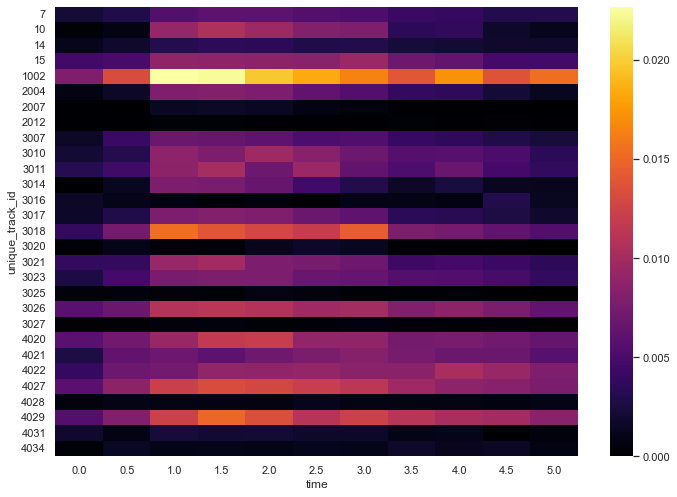

In [550]:
def generate_heatmap_data(feature):

    heatmap_data = fv_transfected[['unique_track_id', 'time', feature]]
    heatmap_data = heatmap_data.drop_duplicates(subset=['unique_track_id', 'time'], keep='first')
    heatmap_data = heatmap_data.pivot('unique_track_id', 'time', feature)

    return heatmap_data

heatmap_data = generate_heatmap_data('blob_sdcGFP_cytoplasm_density')

ax=sns.heatmap(heatmap_data, cmap='inferno')

In [553]:
from scipy.optimize import curve_fit
from scipy.misc import derivative

In [554]:
def func(x, a, b, c):

    return a * np.exp(-b * x) + c


x_data = fv_transfected['time'].loc[fv_transfected['unique_track_id'] == 3007]
y_data = fv_transfected['blob_sdcGFP_cytoplasm_density'].loc[fv_transfected['unique_track_id'] == 3007]

popt, pcov = curve_fit(func, x_data, y_data)

popt

array([-3.17348782e-03,  5.08870449e+00,  4.73390318e-03])

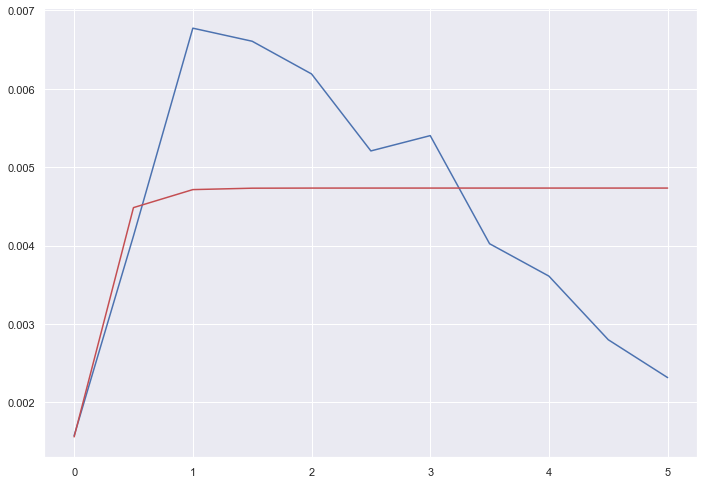

In [555]:
plt.plot(x_data, y_data)
plt.plot(x_data, func(x_data, *popt), 'r-', label='fit: a=%5.3f, b=%5.3f, c=%5.3f' % tuple(popt))

In [556]:

derivative(func, x0=0, args=popt)

0.25732774232713157

In [557]:
def get_nucleation_rate(group):

    x_data = group['time']
    y_data = group['blob_sdcGFP_cytoplasm_density']
    
    try:
        popt, pcov = curve_fit(func, x_data, y_data)
        der = derivative(func, x0=0, args=popt)
        
    except:
        der = np.nan
        
    return der


nucleation_rates = fv_transfected.groupby('unique_track_id').apply(lambda grp: get_nucleation_rate(grp))

In [558]:
fv_transfected = pd.merge(fv_transfected, nucleation_rates.rename('nucleation_rate'), on='unique_track_id')

In [559]:
fv_transfected

,unique_object_id,timepoint,label,area,bbox-0,bbox-1,bbox-2,bbox-3,bbox_area,centroid-0,...,blob_count_sdcGFP_cytoplasm,is_border_cytoplasm,site,unique_track_id,count_cytoplasm,volume_cytoplasm,blob_sdcGFP_cytoplasm_density,time,area_cytoplasm_um,nucleation_rate
0,9,0,10,271055,482,1098,1259,1647,426573,921.848717,...,47.0,0.0,0,7,NaN,21947.250000,0.002141,0.0,21947.250000,1.764650e-02
1,32,1,10,280594,442,1098,1259,1634,437912,923.171818,...,65.0,0.0,0,7,NaN,23189.400000,0.002803,0.5,23189.400000,1.764650e-02
2,52,2,8,256647,549,1098,1259,1647,389790,932.523766,...,121.0,0.0,0,7,NaN,21738.383333,0.005566,1.0,21738.383333,1.764650e-02
3,75,3,8,249821,549,1112,1245,1647,372360,926.709860,...,126.0,0.0,0,7,NaN,21063.250000,0.005982,1.5,21063.250000,1.764650e-02
4,97,4,9,256687,536,1112,1245,1647,379315,926.564933,...,133.0,0.0,0,7,NaN,22008.025000,0.006043,2.0,22008.025000,1.764650e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
314,24000388,6,43,80250,1567,1299,1888,1741,141882,1716.245408,...,4.0,0.0,4,4034,1.0,4064.450000,0.000984,3.0,4064.450000,4.406877e+13
315,24000447,7,47,81148,1553,1312,1874,1741,137709,1711.273315,...,7.0,0.0,4,4034,1.0,4102.366667,0.001706,3.5,4102.366667,4.406877e+13
316,24000507,8,48,80641,1553,1299,1874,1741,141882,1713.953349,...,5.0,0.0,4,4034,1.0,4235.400000,0.001181,4.0,4235.400000,4.406877e+13
317,24000565,9,47,82827,1553,1299,1874,1741,141882,1712.576624,...,7.0,0.0,4,4034,1.0,4723.766667,0.001482,4.5,4723.766667,4.406877e+13
